In [5]:
import json
import os
from google.colab import userdata

# Ensure the .kaggle directory exists
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Path to kaggle.json
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")

# Retrieve credentials from Colab secrets
kaggle_username = userdata.get('KAGGLE_USERNAME')
kaggle_key = userdata.get('KAGGLE_KEY')

if kaggle_username and kaggle_key:
    # Create the kaggle.json file
    kaggle_credentials = {
        "username": kaggle_username,
        "key": kaggle_key
    }
    with open(kaggle_json_path, "w") as f:
        json.dump(kaggle_credentials, f)

    # Set permissions
    os.chmod(kaggle_json_path, 0o600)
    print("Kaggle API key configured from Colab secrets.")
else:
    print("KAGGLE_USERNAME or KAGGLE_KEY not found in Colab secrets. Please add them.")


Kaggle API key configured from Colab secrets.


In [6]:
!kaggle datasets download -d rjn0007/ppeconstruction
!unzip ppeconstruction.zip -d ppeconstruction
!rm ppeconstruction.zip # Clean up the zip file

Dataset URL: https://www.kaggle.com/datasets/rjn0007/ppeconstruction
License(s): apache-2.0
 64% 109M/170M [00:00<00:00, 1.14GB/s]
100% 170M/170M [00:00<00:00, 764MB/s] 
Archive:  ppeconstruction.zip
  inflating: ppeconstruction/LICENSE  
  inflating: ppeconstruction/data.yaml  
  inflating: ppeconstruction/images/test/image1.jpeg  
  inflating: ppeconstruction/images/test/image10.jpeg  
  inflating: ppeconstruction/images/test/image1003.jpg  
  inflating: ppeconstruction/images/test/image1007.jpg  
  inflating: ppeconstruction/images/test/image1009.jpg  
  inflating: ppeconstruction/images/test/image1014.jpg  
  inflating: ppeconstruction/images/test/image1019.jpg  
  inflating: ppeconstruction/images/test/image1023.jpg  
  inflating: ppeconstruction/images/test/image1037.jpeg  
  inflating: ppeconstruction/images/test/image1065.jpg  
  inflating: ppeconstruction/images/test/image1074.jpg  
  inflating: ppeconstruction/images/test/image1076.jpg  
  inflating: ppeconstruction/images/te

In [11]:
import glob
import yaml
# Find the YAML file
WORKING_DIR = "/content/ppeconstruction"
yaml_files = glob.glob(os.path.join(WORKING_DIR, '*.yaml'))
if not yaml_files:
    # Sometimes it's inside a subfolder, let's search recursively just in case
    yaml_files = glob.glob(os.path.join(WORKING_DIR, '**/*.yaml'), recursive=True)

if not yaml_files:
    raise FileNotFoundError("❌ No .yaml file found in dataset!")

yaml_file = yaml_files[0]
print(f"   Found config: {yaml_file}")

target_class_id = -1

with open(yaml_file, 'r') as f:
    data = yaml.safe_load(f)

# A. Find Class ID
raw_names = data['names']
names_dict = {i: n for i, n in enumerate(raw_names)} if isinstance(raw_names, list) else raw_names

for cid, cname in names_dict.items():
    if 'boot' in str(cname).lower() and 'no' in str(cname).lower():
        target_class_id = cid
        print(f"   🎯 Removing Class ID {cid}: {cname}")
        break

# B. Remove from Text Files
if target_class_id != -1:
    txt_files = glob.glob(f'{WORKING_DIR}/**/*.txt', recursive=True)
    for txt in txt_files:
        with open(txt, 'r') as f: lines = f.readlines()
        new_lines = []
        for line in lines:
            parts = line.split()
            if not parts: continue
            cls = int(parts[0])
            if cls == target_class_id: continue
            if cls > target_class_id: parts[0] = str(cls - 1)
            new_lines.append(" ".join(parts) + "\n")
        with open(txt, 'w') as f: f.writelines(new_lines)

    # Update Names
    new_names = {i: n for i, n in enumerate([v for k,v in names_dict.items() if k != target_class_id])}
    data['names'] = new_names
    data['nc'] = len(new_names)


   Found config: /content/ppeconstruction/data.yaml


| Class     |   Count | Percentage   |
|:----------|--------:|:-------------|
| helmet    |    1750 | 15.2%        |
| gloves    |    1461 | 12.7%        |
| vest      |    1632 | 14.2%        |
| boots     |    1613 | 14.0%        |
| goggles   |     526 | 4.6%         |
| none      |     800 | 7.0%         |
| Person    |    2265 | 19.7%        |
| no_helmet |     485 | 4.2%         |
| no_goggle |     411 | 3.6%         |
| no_gloves |     556 | 4.8%         |


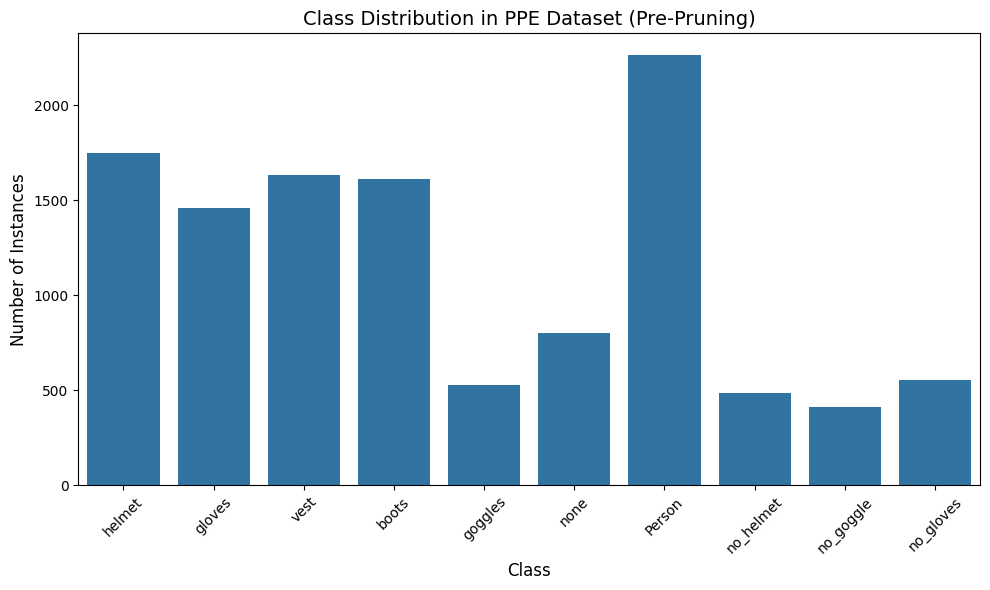

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob
import os # Import os module for directory creation

def analyze_dataset(annotations_path, class_name_map):
    """
    Analyze YOLO format annotations to generate paper statistics
    """
    # Load all annotation files
    class_counts = Counter()
    image_sizes = []
    bbox_areas = []

    # Modified glob.glob to search recursively
    for ann_file in glob.glob(f"{annotations_path}/**/*.txt", recursive=True):
        with open(ann_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                # Check if line is not empty
                if line.strip():
                    parts = line.split()
                    # Ensure there are enough parts to unpack
                    if len(parts) >= 5:
                        class_id, x_center, y_center, width, height = map(float, parts)
                        class_counts[int(class_id)] += 1
                        bbox_areas.append(width * height)

    # Check if class_counts is empty to avoid division by zero and empty DataFrame
    if not class_counts:
        print("No annotations found. Please check the dataset path and file structure.")
        return pd.DataFrame()

    # Create statistics table
    stats_df = pd.DataFrame([
        {
            'Class': class_name_map.get(cls_id, f'Unknown_{cls_id}'),
            'Count': count,
            'Percentage': f"{(count/sum(class_counts.values()))*100:.1f}%"
        }
        for cls_id, count in sorted(class_counts.items())
    ])

    print(stats_df.to_markdown(index=False))

    # Generate class distribution bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(data=stats_df, x='Class', y='Count')
    plt.title('Class Distribution in PPE Dataset (Pre-Pruning)', fontsize=14)
    plt.ylabel('Number of Instances', fontsize=12)
    plt.xlabel('Class', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Ensure 'figures' directory exists
    os.makedirs('figures', exist_ok=True)
    plt.savefig('figures/class_distribution.png', dpi=300)

    return stats_df

# Run analysis - ensure 'new_names' is available from previous cells
stats = analyze_dataset('ppeconstruction/labels', new_names)


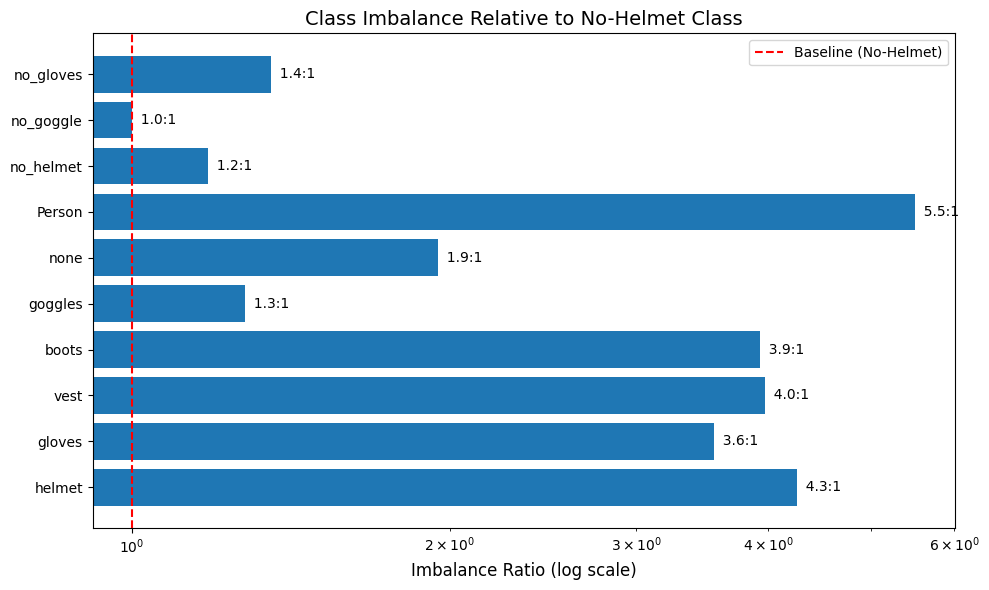

In [15]:
def plot_imbalance_ratio(stats_df):
    """
    Create a log-scale visualization of class imbalance
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate ratios relative to minority class
    min_count = stats_df['Count'].min()
    stats_df['Ratio'] = stats_df['Count'] / min_count

    bars = ax.barh(stats_df['Class'], stats_df['Ratio'], log=True)
    ax.set_xlabel('Imbalance Ratio (log scale)', fontsize=12)
    ax.set_title('Class Imbalance Relative to No-Helmet Class', fontsize=14)
    ax.axvline(x=1, color='red', linestyle='--', label='Baseline (No-Helmet)')

    # Add ratio annotations
    for i, (cls, ratio) in enumerate(zip(stats_df['Class'], stats_df['Ratio'])):
        ax.text(ratio, i, f'  {ratio:.1f}:1', va='center')

    ax.legend()
    plt.tight_layout()
    plt.savefig('figures/imbalance_ratio.png', dpi=300)

plot_imbalance_ratio(stats)

In [16]:
import graphviz

def generate_decision_flowchart():
    dot = graphviz.Digraph(comment='Smart Decision Logic')
    dot.attr(rankdir='TB')

    # Nodes
    dot.node('A', 'YOLO Detection', shape='box')
    dot.node('B', 'Person Detected?', shape='diamond')
    dot.node('C', 'Skip Frame', shape='ellipse')
    dot.node('D', 'Helmet + Vest?', shape='diamond')
    dot.node('E', 'SAFE\n(Fast Path)', shape='box', style='filled', fillcolor='lightgreen')
    dot.node('F', 'No-Helmet Class?', shape='diamond')
    dot.node('G', 'VIOLATION\n(Fast Path)', shape='box', style='filled', fillcolor='red')
    dot.node('H', 'Trigger SAM 3\n(Rescue Path)', shape='box', style='filled', fillcolor='yellow')
    dot.node('I', 'Mask Found?', shape='diamond')
    dot.node('J', 'SAFE\n(Verified)', shape='box', style='filled', fillcolor='lightgreen')
    dot.node('K', 'VIOLATION\n(Verified)', shape='box', style='filled', fillcolor='red')

    # Edges
    dot.edge('A', 'B')
    dot.edge('B', 'C', label='No')
    dot.edge('B', 'D', label='Yes')
    dot.edge('D', 'E', label='Yes')
    dot.edge('D', 'F', label='No')
    dot.edge('F', 'G', label='Yes')
    dot.edge('F', 'H', label='No')
    dot.edge('H', 'I')
    dot.edge('I', 'J', label='Yes')
    dot.edge('I', 'K', label='No')

    dot.render('figures/decision_flowchart', format='png', cleanup=True)

generate_decision_flowchart()